In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from math import comb  # Combinations
from scipy.spatial.distance import euclidean
from itertools import combinations

from utils.ae_torch_classes import *
#from utils.LSTM_gesture_classifier import *

In [2]:
import warnings
warnings.filterwarnings('ignore')
# C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning warnings.warn(

In [10]:
print("Loading")

# Kai's laptop
#data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\PCA_40D\\"
#model_dir_path = 'C:\\Users\\kdmen\\Desktop\\Research\\Repos\\fl-gestures\\models\\Embedding\\Autoencoders\\'
# BRC Desktop
data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\"
model_dir_path = 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\'

emg_dir = "filtered_datasets\\EMG_PPD\\"
both_dir = "filtered_datasets\\Both_PPD\\"

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']
metadata_cols_df = pd.read_pickle('D:\\Kai_MetaGestureClustering_24\\saved_datasets\\metadata_cols_df.pkl')

emg_training_users_df = pd.read_pickle(data_path+emg_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
emg_test_users_df = pd.read_pickle(data_path+emg_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

both_training_users_df = pd.read_pickle(data_path+both_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
both_test_users_df = pd.read_pickle(data_path+both_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

full_emg_df = pd.concat([metadata_cols_df, pd.concat([emg_training_users_df, emg_test_users_df]).reset_index(drop=True)], axis=1)
full_both_df = pd.concat([metadata_cols_df, pd.concat([both_training_users_df, both_test_users_df]).reset_index(drop=True)], axis=1)

Loading


In [11]:
print(full_emg_df.shape)
full_emg_df.head()

(204800, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [12]:
print(full_both_df.shape)
full_both_df.head()

(204800, 91)


,Participant,Gesture_ID,Gesture_Num,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.551109,-0.738972,-0.985439,0.181924,0.059616,0.087024,1.055804,...,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.571115,-0.821726,-0.975036,0.242607,0.067375,-0.024900,1.007074,...,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.509305,-0.823575,-0.947221,0.550111,0.013848,-0.485765,0.993332,...,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.511788,-0.775810,-0.947939,0.417919,0.087222,-0.229441,1.026003,...,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.441369,-0.921726,-0.882652,1.254970,0.108993,-0.933639,1.001748,...,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [6]:
num_rows_per_gesture = 64 # From the interp
batch_size = 32

In [ ]:
# Embedding first..

hidden_dim_lst = [9]
input_dim = 16
RNNAE_9mir_EMGFull = RNNAutoencoder(input_dim, hidden_dim_lst, num_layers=None, seq_len=timesteps, progressive=False, mirror=True)
RNNAE_9mir_EMGFull.load_state_dict(torch.load(model_dir_path+'RNNAE_9mir_vallossp277_EMGFull.pth'))


In [4]:
full_emg_df['Participant'].unique()

array(['P102', 'P103', 'P104', 'P105', 'P106', 'P107', 'P108', 'P109',
       'P110', 'P111', 'P112', 'P114', 'P115', 'P116', 'P118', 'P119',
       'P121', 'P122', 'P123', 'P124', 'P125', 'P126', 'P127', 'P128',
       'P131', 'P132', 'P004', 'P005', 'P006', 'P008', 'P010', 'P011'],
      dtype=object)

In [5]:
full_emg_df.columns

Index(['Participant', 'Gesture_ID', 'Gesture_Num', 'EMG1', 'EMG2', 'EMG3',
       'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG9', 'EMG10', 'EMG11',
       'EMG12', 'EMG13', 'EMG14', 'EMG15', 'EMG16'],
      dtype='object')

In [14]:
from scipy.spatial.distance import cdist

In [16]:
df = full_emg_df

# Step 1: Group by 'Participant', 'Gesture_ID', and 'Gesture_Num' to identify unique gestures
grouped = df.groupby(['Participant', 'Gesture_ID', 'Gesture_Num'])

# Step 2: Extract the submatrices for each gesture
gesture_submatrices = [group[1].iloc[:, 3:].values for group in grouped]  # Extract EMG columns only


In [17]:
# Step 3: Calculate the pairwise distances between the submatrices
# Define a custom distance function that operates on submatrices
def submatrix_distance(mat1, mat2, metric='euclidean',  norm='fro', method='mean'):
    # metric: cityblock, chebyshev, cosine
    # norm: mean, fro, np.inf
    if method=='both':
        if norm=='mean':
            return np.mean(cdist(mat1, mat2, metric=metric))
        elif norm=='fro' or norm==np.inf:
            return np.linalg.norm(mat1 - mat2, norm)
        else:
            raise ValueError(f"norm {norm} not recognized")
    elif method=='norm':
        return np.linalg.norm(mat1 - mat2, norm)
    elif method=='mean':
        return np.mean(cdist(mat1, mat2, metric=metric))
    else:
        raise ValueError(f"method {method} not recognized")

In [19]:
start_time = time.time()

# Create a distance matrix
num_gestures = len(gesture_submatrices)
distance_matrix = np.zeros((num_gestures, num_gestures))

for i in range(num_gestures):
    for j in range(i, num_gestures):
        dist = submatrix_distance(gesture_submatrices[i], gesture_submatrices[j])
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist

print(f"Completed in {time.time() - start_time}s")

Completed in 407.11214447021484s


In [20]:
# Step 4: Plot the distance matrix using a heatmap
# Create labels for gestures
gesture_labels = [f'{key[0]}-{key[1]}-{key[2]}' for key in grouped.groups.keys()]

In [22]:
gesture_labels

['P004-close-1',
 'P004-close-10',
 'P004-close-2',
 'P004-close-3',
 'P004-close-4',
 'P004-close-5',
 'P004-close-6',
 'P004-close-7',
 'P004-close-8',
 'P004-close-9',
 'P004-delete-1',
 'P004-delete-10',
 'P004-delete-2',
 'P004-delete-3',
 'P004-delete-4',
 'P004-delete-5',
 'P004-delete-6',
 'P004-delete-7',
 'P004-delete-8',
 'P004-delete-9',
 'P004-duplicate-1',
 'P004-duplicate-10',
 'P004-duplicate-2',
 'P004-duplicate-3',
 'P004-duplicate-4',
 'P004-duplicate-5',
 'P004-duplicate-6',
 'P004-duplicate-7',
 'P004-duplicate-8',
 'P004-duplicate-9',
 'P004-move-1',
 'P004-move-10',
 'P004-move-2',
 'P004-move-3',
 'P004-move-4',
 'P004-move-5',
 'P004-move-6',
 'P004-move-7',
 'P004-move-8',
 'P004-move-9',
 'P004-open-1',
 'P004-open-10',
 'P004-open-2',
 'P004-open-3',
 'P004-open-4',
 'P004-open-5',
 'P004-open-6',
 'P004-open-7',
 'P004-open-8',
 'P004-open-9',
 'P004-pan-1',
 'P004-pan-10',
 'P004-pan-2',
 'P004-pan-3',
 'P004-pan-4',
 'P004-pan-5',
 'P004-pan-6',
 'P004-pa

In [26]:
df.head()

,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


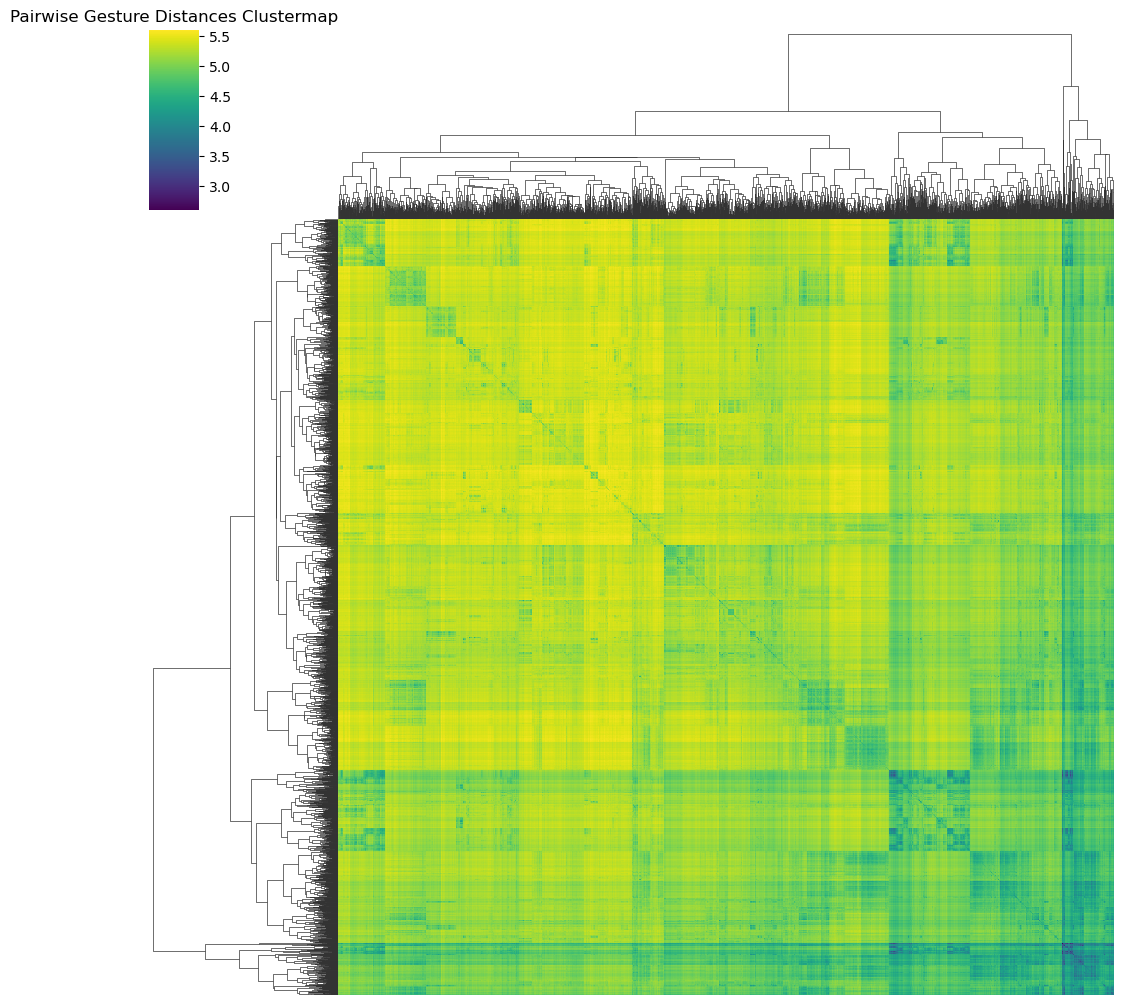

In [47]:
#sns.clustermap(distance_matrix, xticklabels=gesture_labels, yticklabels=gesture_labels, cmap='viridis')
ecu_clustermap_ecu_mean_NOLABELS = sns.clustermap(distance_matrix, metric='euclidean', cmap='viridis', method='average', xticklabels=False, yticklabels=False)
plt.title('Pairwise Gesture Distances Clustermap')
plt.show()

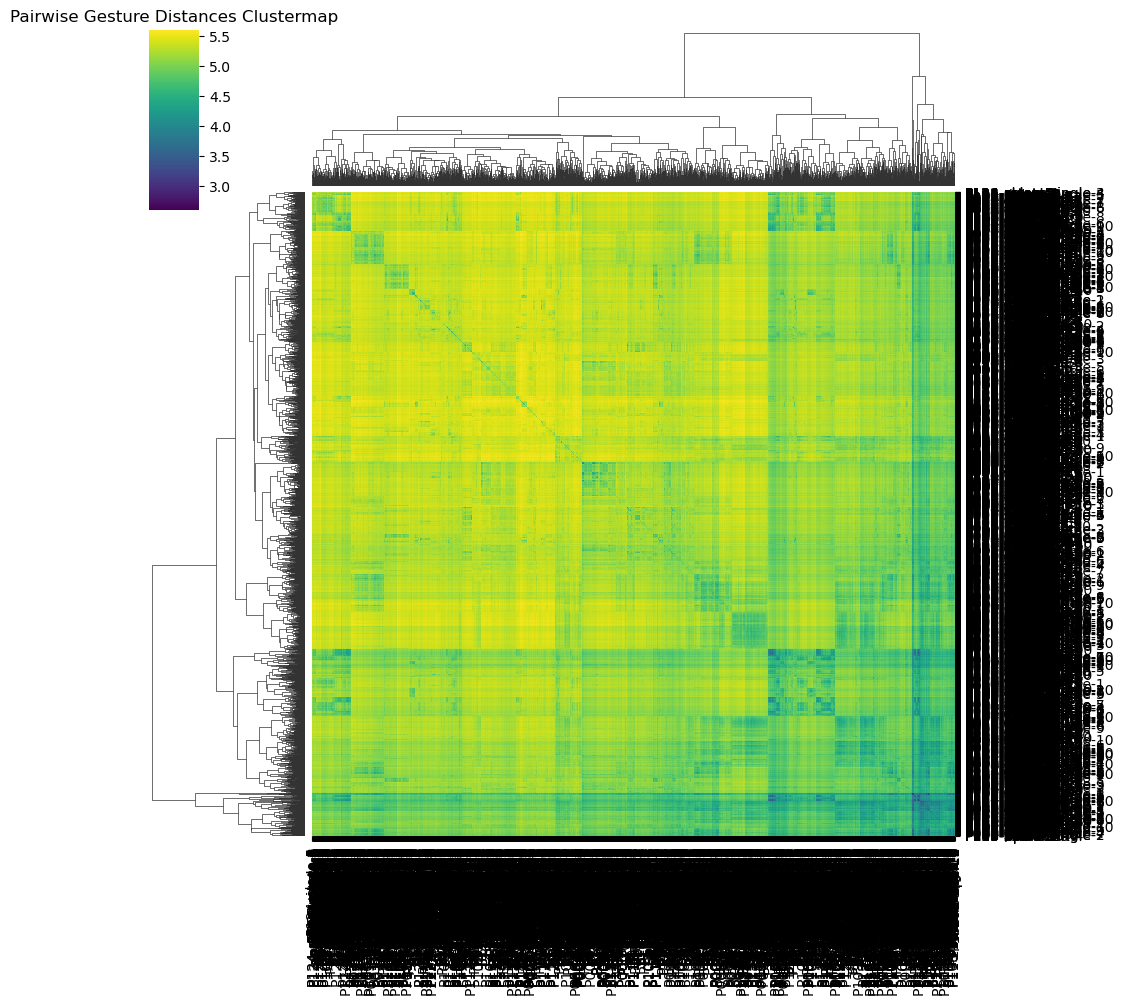

In [48]:
ecu_clustermap_ecu_mean = sns.clustermap(distance_matrix, xticklabels=gesture_labels, yticklabels=gesture_labels, cmap='viridis')
plt.title('Pairwise Gesture Distances Clustermap')
plt.show()

In [38]:
# Access dendrogram information for rows and columns
dendrogram_row = ecu_clustermap_ecu_mean.dendrogram_row
dendrogram_col = ecu_clustermap_ecu_mean.dendrogram_col

# Get the cluster assignments for rows and columns
## Row and col are the same for me!
row_clusters = dendrogram_row.dendrogram['leaves']
col_clusters = dendrogram_col.dendrogram['leaves']

In [39]:
# Print the cluster assignments
print("Row clusters:", row_clusters)

Row clusters: [2505, 2573, 2574, 2560, 2332, 2333, 909, 968, 967, 908, 960, 2519, 2575, 969, 2243, 958, 2245, 2246, 1285, 1289, 266, 263, 1287, 1286, 223, 1283, 1284, 2535, 2280, 2527, 2572, 2551, 2555, 17, 18, 1627, 1623, 1626, 1649, 1620, 1625, 1641, 1648, 15, 220, 11, 16, 2518, 251, 257, 2395, 2570, 2577, 2284, 2285, 2502, 250, 2286, 2533, 2529, 255, 259, 262, 2288, 936, 2583, 939, 2541, 2599, 978, 2598, 2554, 2522, 2398, 2399, 976, 2339, 2503, 260, 264, 20, 2512, 256, 258, 253, 252, 254, 2511, 2550, 2566, 2534, 2553, 2528, 2521, 2552, 934, 2537, 2569, 2532, 2568, 929, 932, 2210, 966, 2212, 964, 965, 2564, 2296, 925, 963, 2559, 937, 2298, 923, 2565, 2093, 2041, 2045, 1464, 893, 895, 2578, 1265, 1292, 1209, 1201, 1208, 1261, 823, 1243, 917, 916, 918, 950, 910, 912, 2016, 911, 919, 913, 954, 915, 914, 2012, 1207, 1290, 1297, 2334, 824, 801, 802, 2049, 2043, 3119, 920, 2576, 907, 2562, 904, 906, 903, 926, 930, 901, 951, 2571, 2579, 961, 2295, 2228, 2001, 985, 955, 2208, 2217, 2293, 897

In [41]:
len(row_clusters)

3200

In [44]:
len(set(row_clusters))

3200

In [45]:
# Determine the number of levels in the dendrogram
num_levels_row = len(dendrogram_row.dendrogram['icoord'])
num_levels_col = len(dendrogram_col.dendrogram['icoord'])

# Print the number of levels
print("Number of levels in row dendrogram:", num_levels_row)
print("Number of levels in column dendrogram:", num_levels_col)

Number of levels in row dendrogram: 3199
Number of levels in column dendrogram: 3199


In [ ]:
level = 

row_clusters_at_level = dendrogram_row.dendrogram['icoord'][level]
#col_clusters_at_level = dendrogram_col.dendrogram['icoord'][level]
print("Row clusters at level", level, ":", row_clusters_at_level)